# LANGUAGE MODELING WITH LSTM

<center>This project is an NLP project for word prediction, the model will predict the next work in a sentence. The data set is the Penn Treebank data set which contains lots correct English sentences. The data set contains training, testing and validation set, which we are going to use the training set for training and the testing set for validation. We will divide the data set into 20 word per sentence, i.e each sequence will contain 20 time steps. So we go over the training and analyze the training performance and  the validation performance. we will be using tensorflow library<center>

In [1]:
!pip install altair

In [2]:
import time
import numpy as np
import tensorflow as tf
print(tf.__version__ )

2.11.0


In [3]:
# importing neccessary packages
import matplotlib.pyplot as plt
import collections
import os

import numpy as np
import tensorflow as tf

Writting a function to get our data set from the directory, the function will return a list which contains every sentence in numbers, i.e each word is represented with a number which is its index and a dictionary which contains each word as key and index as value

In [4]:
def get_data(filename):
    #define the directory to get our data set
    file_path = os.path.join(data_dir, filename)
    #read our data from the directory and replace every new line with <eos>, (end of sentence)
    with tf.io.gfile.GFile(file_path, "r") as f:
        file=f.read().replace("\n", "<eos>").split()
        
    word_to_id_path= os.path.join(data_dir, 'ptb.train.txt')
    with tf.io.gfile.GFile(word_to_id_path, "r") as f:
        word_to_id_file=f.read().replace("\n", "<eos>").split()
        
    #arrang each word in our data set according to their indexes
    counter = collections.Counter(word_to_id_file)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    words, count = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    sen_no= [word_to_id[word] for word in file if word in word_to_id]
    
    return sen_no, word_to_id


we can now get our data set according to the indexes of each word and every sentence in the data set represented in numbers.

In [5]:
data_dir = "data/simple-examples/data/"

#train data set
train_sen_no, word_to_id = get_data('ptb.train.txt')
#validation data set
va_sen_no, word_to_id = get_data('ptb.valid.txt')
#testing set
test_va_sen_no, word_to_id = get_data('ptb.test.txt')
#get lenght of the word id 
len(word_to_id), len(train_sen_no)

(10000, 929589)

write a function to transform the sentence to words from numbers

In [6]:
def id_to_word(vocab, id_list):
    line = []
    for w in id_list:
        for word, wid in vocab.items():
            if wid == w:
                line.append(word)
    return line            
                

In [7]:
# the first 100 words
words_no=train_sen_no[0:100]
#print the first 100 words
print(np.reshape(words_no, (1, -1)))

[[9970 9971 9972 9974 9975 9976 9980 9981 9982 9983 9984 9986 9987 9988
  9989 9991 9992 9993 9994 9995 9996 9997 9998 9999    2 9256    1    3
    72  393   33 2133    0  146   19    6 9207  276  407    3    2   23
     1   13  141    4    1 5465    0 3081 1596   96    2 7682    1    3
    72  393    8  337  141    4 2477  657 2170  955   24  521    6 9207
   276    4   39  303  438 3684    2    6  942    4 3150  496  263    5
   138 6092 4241 6036   30  988    6  241  760    4 1015 2786  211    6
    96    4]]


In [8]:
# getting the it in alphabetic form
np.reshape(id_to_word(word_to_id, words_no), (1,-1))

array([['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett',
        'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia',
        'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens',
        'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter', '<eos>',
        'pierre', '<unk>', 'N', 'years', 'old', 'will', 'join', 'the',
        'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'N',
        '<eos>', 'mr.', '<unk>', 'is', 'chairman', 'of', '<unk>', 'n.v.',
        'the', 'dutch', 'publishing', 'group', '<eos>', 'rudolph',
        '<unk>', 'N', 'years', 'old', 'and', 'former', 'chairman', 'of',
        'consolidated', 'gold', 'fields', 'plc', 'was', 'named', 'a',
        'nonexecutive', 'director', 'of', 'this', 'british',
        'industrial', 'conglomerate', '<eos>', 'a', 'form', 'of',
        'asbestos', 'once', 'used', 'to', 'make', 'kent', 'cigarette',
        'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of',
        'cancer', 'de

define a function to get an itrator for our data set. the function will return an itrator which contains our data set in batch size and time step

In [9]:
def loader(file, batch_size,num_steps):
    raw_data = np.array(file, dtype=np.int32)
    data_len = len(raw_data)
    batch_len = data_len // batch_size
    data = np.zeros([batch_size, batch_len], dtype=np.int32)
    for i in range(batch_size):
        data[i] = raw_data[batch_len * i:batch_len * (i + 1)]
        
    epoch_size = (batch_len - 1) // num_steps
    for i in range(epoch_size):
        x = data[:, i*num_steps:(i+1)*num_steps]
        y = data[:, i*num_steps+1:(i+1)*num_steps+1]
        
        yield(x, y)

In [10]:
# using our itrator loader to get  generrate our data set in 30 batches and 20 time steps
train_itter=loader(train_sen_no,30, 20)


In [11]:
test_itter=loader(test_va_sen_no, 30, 30)

In [12]:
# get the first training batch
first_touple = train_itter.__next__()
features = first_touple[0]
targets = first_touple[1]

In [13]:
targets.shape

(30, 20)

Defining embedding layer for our model. each word will have 200 embedding vectors

In [14]:
batch_size=30
num_steps=20
emddind_size=1000
# set device to cpu since we dont have gpu
with tf.device("/cpu:0"):
    embedding = tf.keras.layers.Embedding(len(word_to_id),emddind_size ,batch_input_shape=(batch_size, num_steps),trainable=True,name="embedding_vocab")
#pass the first batch to the embedding layer 
model_input=embedding(features)

In [15]:
# get the shape of the output of the embedding layer
model_input.shape

TensorShape([30, 20, 1000])

Defining the LSTM cells and stacking them to build our model

In [16]:
lstm_cell_l1 = tf.keras.layers.LSTMCell(250)
lstm_cell_l2 = tf.keras.layers.LSTMCell(128)
stacked_lstm = tf.keras.layers.StackedRNNCells([lstm_cell_l1, lstm_cell_l2])
layer  =  tf.keras.layers.RNN(stacked_lstm,[30, 20],return_state=False,stateful=True,trainable=True)

In [17]:
#initializing our rnn  initial state to zeros
init_state = tf.Variable(tf.zeros([30,1000]),trainable=False)
layer.inital_state = init_state

Input the output of our embedding layer to our RNN layer

In [18]:
# pass the ouput of embedding layer to RNN layer
rnn_out_put=layer(model_input)
rnn_out_put.shape

TensorShape([30, 20, 128])

build fully connected layer and the output is 1000 which represents each word in the word id

In [19]:
#define dense layer
dense = tf.keras.layers.Dense(10000)

In [20]:
#pass the output of the RNN layer to the fully connected layer
densed_output=dense(rnn_out_put)
densed_output.shape

TensorShape([30, 20, 10000])

In [21]:
#define a sofmax function
activation = tf.keras.layers.Activation('softmax')

In [22]:
# pass the output of the fully connected layer to get the probability of each word
prob= activation(densed_output)
prob.shape

TensorShape([30, 20, 10000])

In [23]:
#use argmax function to get the predicted words for the third sequence
yhat=np.argmax(prob[3,0:20], axis=1)
yhat

array([7927, 3151,  911, 8653, 8653, 4065, 4065, 4065, 4065, 1142, 1142,
       4520, 8528, 8528, 8528, 8528, 7844, 7844, 9766, 9766], dtype=int64)

In [24]:
# get the predicted words in alpherbets
np.reshape(id_to_word(word_to_id, yhat), (1,-1))

array([['chooses', 'attitude', 'needed', 'beefeater', 'beefeater',
        'adults', 'adults', 'adults', 'adults', 'democrats', 'democrats',
        'nashua', 'von', 'von', 'von', 'von', 'alarm', 'alarm',
        'patience', 'patience']], dtype='<U9')

In [25]:
# get the actual word
np.reshape(id_to_word(word_to_id, targets[3]), (1,-1))

array([['shares', 'of', 'its', 'common', 'stock', 'for', 'each', 'of',
        '<unk>', 'deposit', "'s", 'N', 'shares', 'outstanding', '<eos>',
        'liberty', 'national', 'a', 'bank', 'holding']], dtype='<U11')

In [26]:
#define a function to calculate our crossentropy loss
def crossentropy(y_true, y_pred):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

In [27]:
targets.shape, prob.shape

((30, 20), TensorShape([30, 20, 10000]))

In [28]:
# calculate the loss of our model output with respect to the actual value
loss=crossentropy(targets, prob)
loss.shape

TensorShape([30, 20])

In [29]:
#calculate the average loss of our prediction
cost = tf.reduce_sum(loss) / batch_size
cost

<tf.Tensor: shape=(), dtype=float32, numpy=184.20879>

In [30]:
# define a variable for our learning rate
lr = tf.Variable(0.0, trainable=False)
# set our optimizer (gradient decent)
optimizer = tf.keras.optimizers.SGD(lr=lr, clipnorm=5)

In [31]:
print(optimizer.learning_rate)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.01>


In [32]:
# set our learning rate to 1.0
K = tf.keras.backend 
K.set_value(optimizer.learning_rate,1.0)

In [33]:
# checking if the learning rate was properly set
optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>

we can now build our model

In [34]:
model=tf.keras.Sequential()
model.add(embedding)
model.add(layer)
model.add(dense)
model.add(activation)
model.compile(loss=crossentropy, optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_vocab (Embedding)  (30, 20, 1000)           10000000  
                                                                 
 rnn (RNN)                   (30, 20, 128)             1475048   
                                                                 
 dense (Dense)               (30, 20, 10000)           1290000   
                                                                 
 activation (Activation)     (30, 20, 10000)           0         
                                                                 
Total params: 12,765,048
Trainable params: 12,735,048
Non-trainable params: 30,000
_________________________________________________________________


In [35]:
# testing our model by passing the first batch along with the time taken in second
start=time.time()
yhat=model(features)
finish=time.time()
total=finish-start
print(total, yhat.shape)

0.39854979515075684 (30, 20, 10000)


In [36]:
#inspecting our tainable paremeters
tvars = model.trainable_variables
for i in tvars:
    print(i.name, i.shape)

embedding_vocab/embeddings:0 (10000, 1000)
rnn/stacked_rnn_cells/lstm_cell/kernel:0 (1000, 1000)
rnn/stacked_rnn_cells/lstm_cell/recurrent_kernel:0 (250, 1000)
rnn/stacked_rnn_cells/lstm_cell/bias:0 (1000,)
rnn/stacked_rnn_cells/lstm_cell_1/kernel:0 (250, 512)
rnn/stacked_rnn_cells/lstm_cell_1/recurrent_kernel:0 (128, 512)
rnn/stacked_rnn_cells/lstm_cell_1/bias:0 (512,)
dense/kernel:0 (128, 10000)
dense/bias:0 (10000,)


<b>Training phase. </b> defining a function the train our training set and analyzing the the training loss and the perplexity. In the training phase, the learning rate was set to decay when a particular threshold is reached and we also applied max_grad_norm to clip our gradients to avoid exploding gradients problems

In [37]:
train_epoc_cost_list=[]
train_perplexity_list=[]
def train(epoc_size):
    
    
    # epoc itration
    for i in range(epoc_size):
        print('epoc {} begins'.format(i+1))
        epoc_cost_list=[]
        perplexity_list=[]
        train_itter=loader(train_sen_no,30, 20)
        #define decay condtion
        if epoc_size >= max_epoch_decay_lr:
            lr_decay = decay ** max(i - max_epoch_decay_lr, 0.0)
            dcr = learning_rate * lr_decay
            K.set_value(model.optimizer.learning_rate,dcr)
        learning_r= model.optimizer.learning_rate
        print('epoc {} learning rate is {}'.format(i+1, learning_r))
        epoc_cost=0
        itter=0
        couter=0
        # batch training
        for batch in train_itter:
            x=batch[0]
            y=batch[1]
            with tf.GradientTape() as tape:
                prob = model(x)
                loss  = crossentropy(y, prob)
                cost = tf.reduce_sum(loss,axis=0) / batch_size
                batch_cost= tf.reduce_sum(loss) / batch_size
                
            #calculate gradient
            grad_t_list = tape.gradient(cost, tvars)
            #clip gradients
            grads, _ = tf.clip_by_global_norm(grad_t_list, max_grad_norm)
            #update our parameters with respect to gradient
            train_op = optimizer.apply_gradients(zip(grads, tvars))
            #append train loss
            train_epoc_cost_list.append(batch_cost)
            epoc_cost_list.append(batch_cost)
            # count loss
            epoc_cost+=batch_cost
            itter+=step_size
            #calculate perplexity
            perplexity= np.exp(epoc_cost/itter)
            perplexity_list.append(perplexity)
            train_perplexity_list.append(perplexity)
            
            #print perplexity for every 500 batches
            if couter % 500==0:
                print('perplexity is {}'.format(perplexity))
            couter+=1
        print('epoc {} completed'.format(i+1))
        print('epoc {} final perplexity is {}'.format(i+1, perplexity))
         
            #vizualize a plot of out training loss and perplexity for every epoc
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[ 0].plot(np.array(epoc_cost_list))
        axes[ 0].set_title('epoc cost')
        axes[ 0].set_xlabel('batches')
        axes[ 0].set_ylabel('cost')
        axes[ 0].grid(True)
        
        axes[ 1].plot(np.array(perplexity_list))
        axes[ 1].set_title('perplexity plot')
        axes[ 1].set_xlabel('batches')
        axes[ 1].set_ylabel('perplexity')
        axes[ 1].grid(True)
            
            
        plt.tight_layout()
        plt.show()
        
  

### Train the model with 10 epocs and learning rate of 1.0 which learning rate will start decaying at max epoc of 7

epoc 1 begins
epoc 1 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 10001.775390625
perplexity is 639.3652954101562
perplexity is 422.9847412109375
perplexity is 339.2154235839844
epoc 1 completed
epoc 1 final perplexity is 334.26751708984375


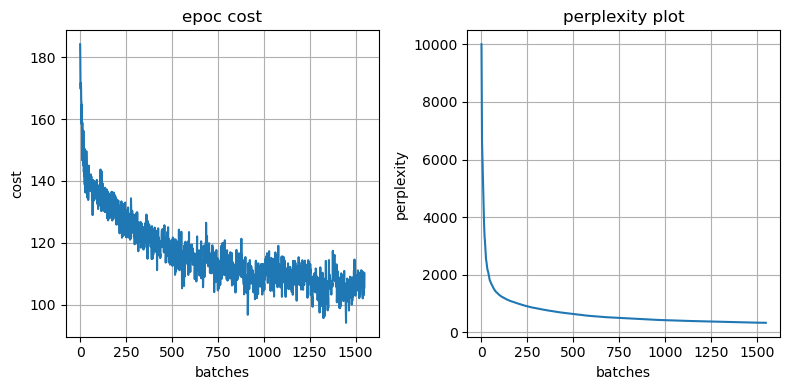

epoc 2 begins
epoc 2 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 281.57666015625
perplexity is 182.5446014404297
perplexity is 165.5905303955078
perplexity is 156.4928741455078
epoc 2 completed
epoc 2 final perplexity is 156.11581420898438


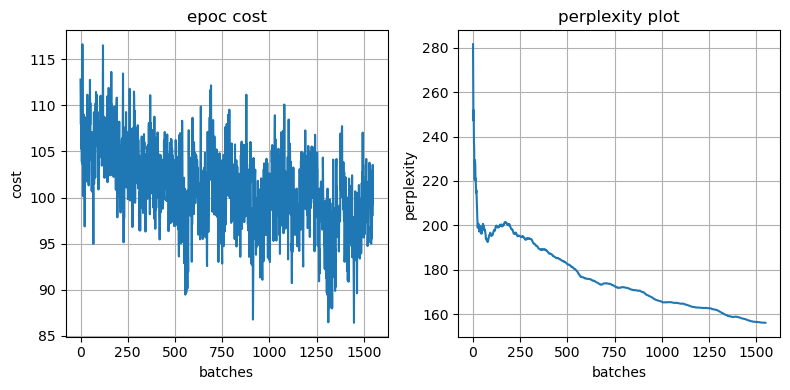

epoc 3 begins
epoc 3 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 225.71849060058594
perplexity is 131.4440155029297
perplexity is 123.1207046508789
perplexity is 118.82301330566406
epoc 3 completed
epoc 3 final perplexity is 118.78414916992188


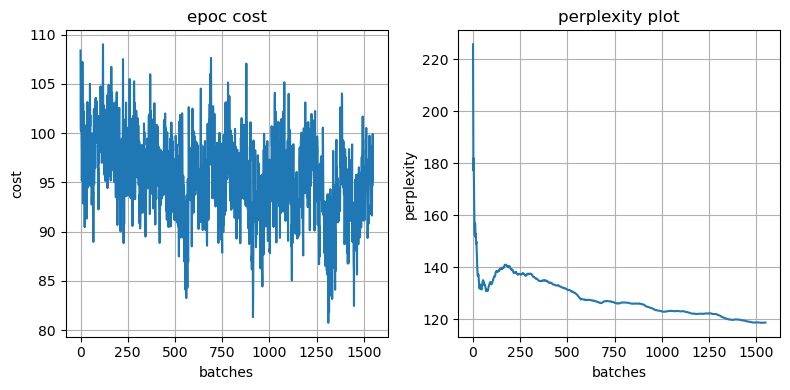

epoc 4 begins
epoc 4 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 190.5298309326172
perplexity is 108.1048583984375
perplexity is 102.46217346191406
perplexity is 99.79117584228516
epoc 4 completed
epoc 4 final perplexity is 99.8627700805664


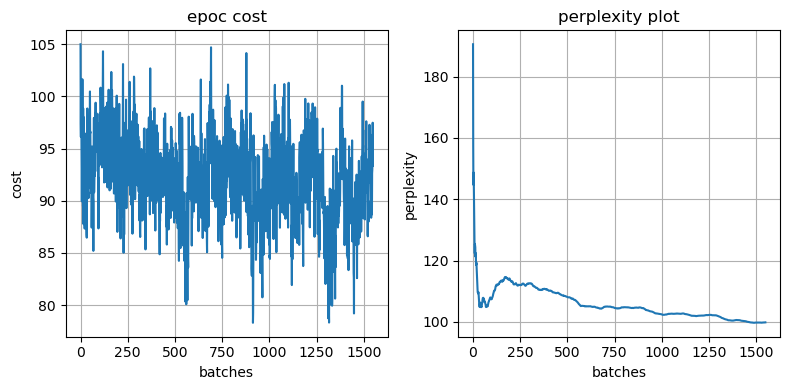

epoc 5 begins
epoc 5 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 174.3499755859375
perplexity is 93.78050231933594
perplexity is 89.5035629272461
perplexity is 87.58068084716797
epoc 5 completed
epoc 5 final perplexity is 87.66436767578125


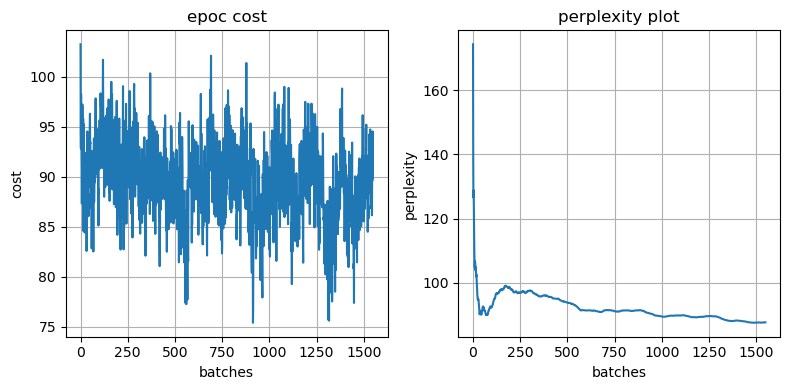

epoc 6 begins
epoc 6 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 161.16787719726562
perplexity is 83.49908447265625
perplexity is 79.89097595214844
perplexity is 78.34967041015625
epoc 6 completed
epoc 6 final perplexity is 78.4350814819336


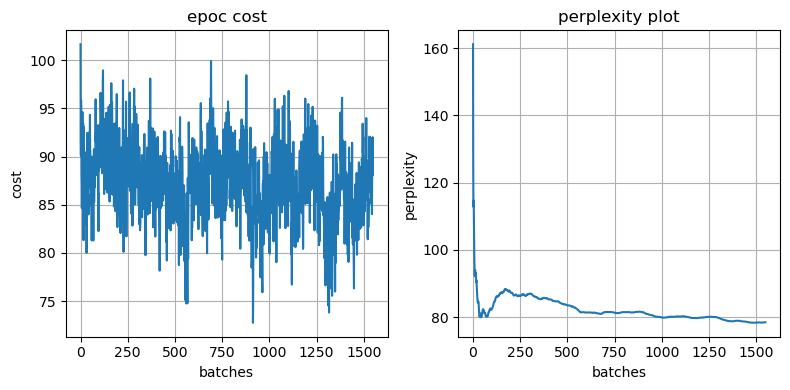

epoc 7 begins
epoc 7 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 145.1846466064453
perplexity is 75.51827239990234
perplexity is 72.5012435913086
perplexity is 71.3391342163086
epoc 7 completed
epoc 7 final perplexity is 71.44572448730469


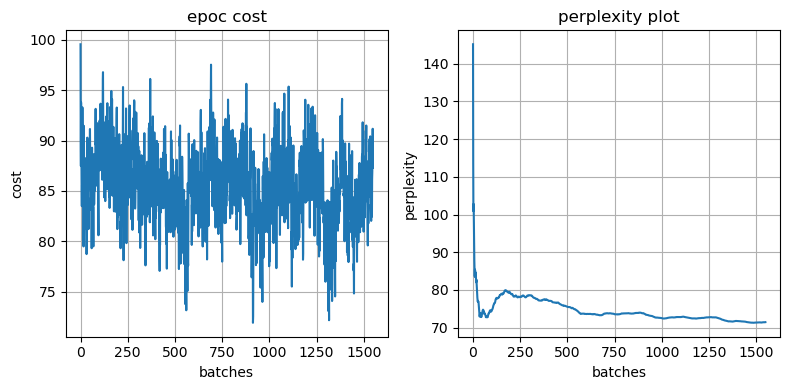

epoc 8 begins
epoc 8 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 132.68540954589844
perplexity is 69.62541961669922
perplexity is 66.94690704345703
perplexity is 65.98014831542969
epoc 8 completed
epoc 8 final perplexity is 66.09552764892578


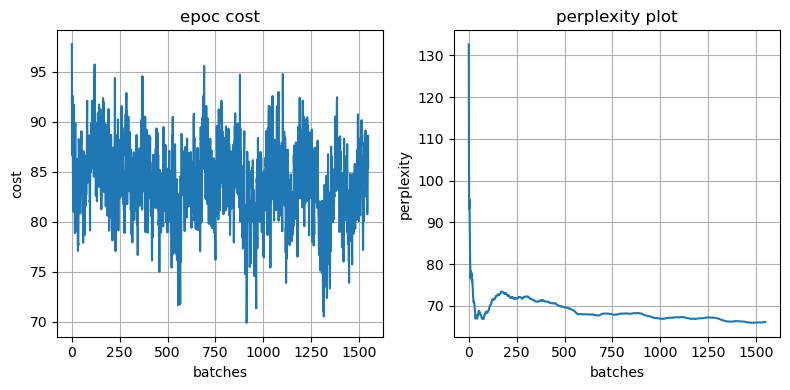

epoc 9 begins
epoc 9 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 122.2998275756836
perplexity is 64.71351623535156
perplexity is 62.42995071411133
perplexity is 61.62437438964844
epoc 9 completed
epoc 9 final perplexity is 61.72757339477539


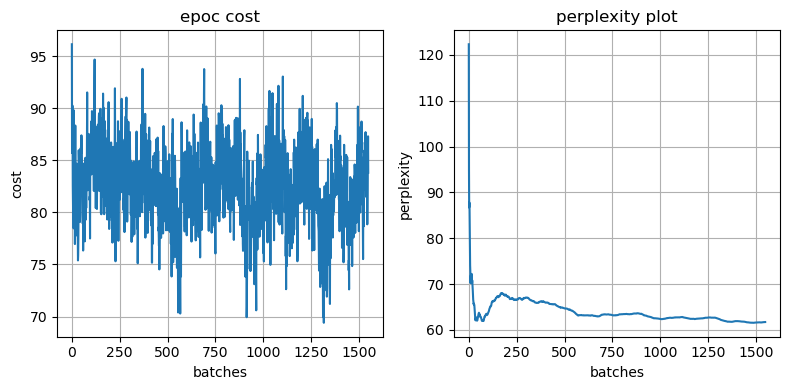

epoc 10 begins
epoc 10 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.5>
perplexity is 119.62979125976562
perplexity is 57.236270904541016
perplexity is 52.814266204833984
perplexity is 50.10236358642578
epoc 10 completed
epoc 10 final perplexity is 50.00313949584961


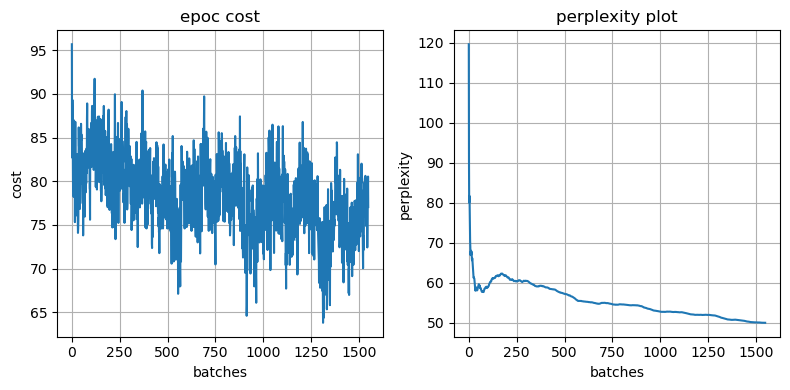

epoc 11 begins
epoc 11 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.25>
perplexity is 100.70918273925781
perplexity is 47.88512420654297
perplexity is 43.925804138183594
perplexity is 41.24210739135742
epoc 11 completed
epoc 11 final perplexity is 41.112911224365234


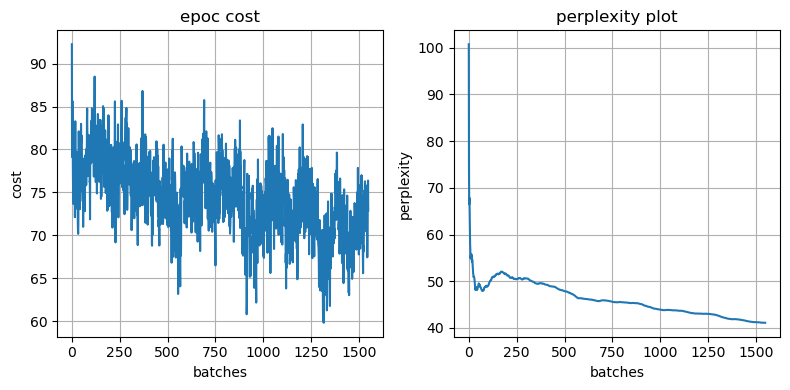

epoc 12 begins
epoc 12 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.125>
perplexity is 93.46973419189453
perplexity is 42.591941833496094
perplexity is 39.00619125366211
perplexity is 36.50790786743164
epoc 12 completed
epoc 12 final perplexity is 36.38214111328125


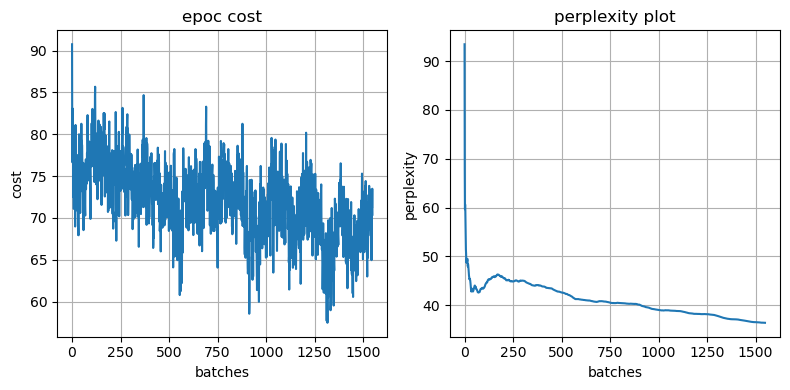

epoc 13 begins
epoc 13 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0625>
perplexity is 88.22049713134766
perplexity is 39.974727630615234
perplexity is 36.59562301635742
perplexity is 34.1948127746582
epoc 13 completed
epoc 13 final perplexity is 34.07200241088867


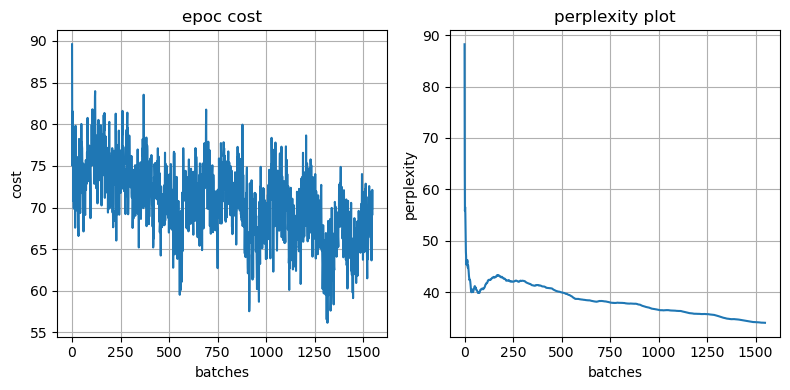

epoc 14 begins
epoc 14 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.03125>
perplexity is 85.15850067138672
perplexity is 38.70016098022461
perplexity is 35.42487716674805
perplexity is 33.05070877075195
epoc 14 completed
epoc 14 final perplexity is 32.928043365478516


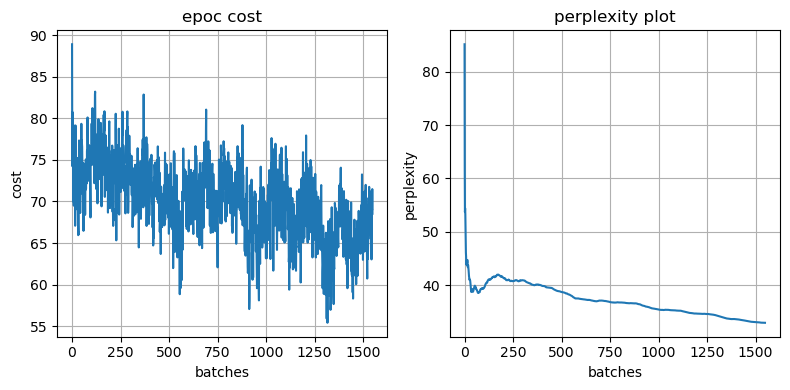

epoc 15 begins
epoc 15 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.015625>
perplexity is 83.91587829589844
perplexity is 38.025146484375
perplexity is 34.795433044433594
perplexity is 32.431983947753906
epoc 15 completed
epoc 15 final perplexity is 32.30826950073242


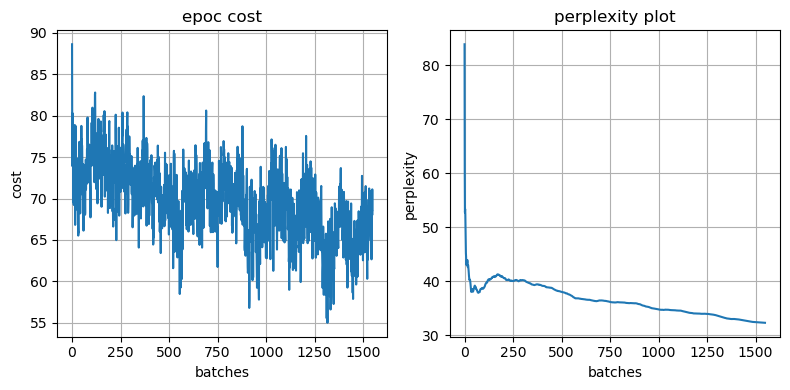

epoc 16 begins
epoc 16 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0078125>
perplexity is 83.17486572265625


KeyboardInterrupt: 

In [38]:
step_size=20
K = tf.keras.backend 
learning_rate=1.0
max_grad_norm=5
decay=0.5
max_epoch_decay_lr=8
start=time.time()
train(20)
finish=time.time()
total=(finish-start)/(60*60)
print('time taken for training is {} hours'.format(total))
model.save('my_model_3.h5')


In [39]:
model.save('my_model_3.h5')

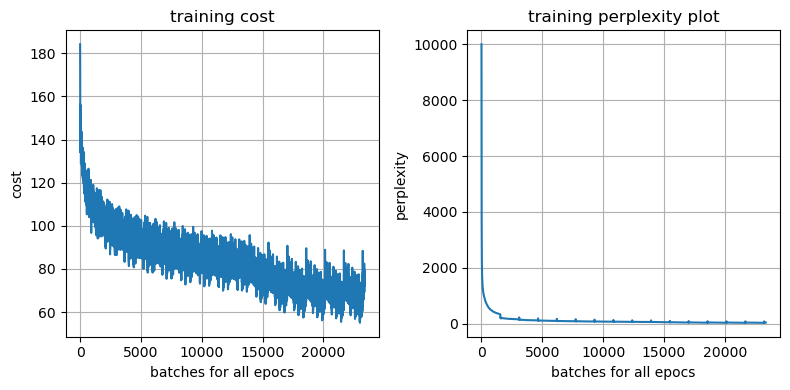

In [40]:
#plot training loss and perplexity
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[ 0].plot(np.array(train_epoc_cost_list))
axes[ 0].set_title('training cost')
axes[ 0].set_xlabel('batches for all epocs')
axes[ 0].set_ylabel('cost')
axes[ 0].grid(True)
        
axes[ 1].plot(np.array(train_perplexity_list))
axes[ 1].set_title('training perplexity plot')
axes[ 1].set_xlabel('batches for all epocs')
axes[ 1].set_ylabel('perplexity')
axes[ 1].grid(True)
            
            
plt.tight_layout()
plt.show()

now lets test our model on testing set

In [41]:
test_epoc_cost_list=[]
test_perplexity_list=[]
couter=0
epoc_cost=0
itter=0
test_itter=loader(test_va_sen_no, 30, 20)
for batch in test_itter:
    x=batch[0]
    y=batch[1]
    
    prob = model(x)
    loss  = crossentropy(y, prob)
    batch_cost= tf.reduce_sum(loss) / batch_size
    test_epoc_cost_list.append(batch_cost)
    
    epoc_cost+=batch_cost
    itter+=20
    #calculate perplexity
    perplexity= np.exp(epoc_cost/itter)
    test_perplexity_list.append(perplexity)
    #print perplexity at every 100 batches
    if couter % 100==0:
        print('perplexity is {}'.format(perplexity))
    couter+=1

perplexity is 199.34429931640625
perplexity is 131.4217071533203


Lets take a look at the output of the model for the first batch 

In [58]:
test_batch=loader(test_va_sen_no, 30, 20)
test_batch=loader(test_va_sen_no, 30, 20)

sample=next(train_itter)
x, y =sample[0], sample[1]
prob=model(x)
yhat=np.argmax(prob[20,0:20], axis=1)
yhat

array([   4,    0,    2,   26,    1,    5,  254,   52,    2,    0,   37,
        263,    6, 1078,   12,    4,   12,    3,   21,   11], dtype=int64)

In [59]:
y[20]

array([   4,  824,  247,   26, 1398,    5,  388,   52,    2,    0, 1834,
         50,    6, 1541,  252,    4,   12,    3,   21,    7])

In [60]:
np.reshape(id_to_word(word_to_id, yhat), (1, -1))

array([['of', 'the', '<eos>', 'are', '<unk>', 'to', 'pay', 'up', '<eos>',
        'the', 'company', 'used', 'a', 'minimum', '$', 'of', '$', 'N',
        'million', 'for']], dtype='<U7')

In [62]:
np.reshape(id_to_word(word_to_id, y[0]), (1, -1))

array([['enters', 'the', '<unk>', 'with', 'even', 'brief', 'exposures',
        'to', 'it', 'causing', 'symptoms', 'that', 'show', 'up',
        'decades', 'later', 'researchers', 'said', '<eos>', '<unk>']],
      dtype='<U11')

## Analysis on the embedding layer of the model

Now that we are done with the training of the model. We can now look at how the embedding layer embedds each word

In [63]:
words=np.array(list(word_to_id.keys()))

In [64]:
ID=np.array(list(word_to_id.values()))

In [65]:
import pandas as pd

In [66]:
# making a data frame of the vocabulary and the word id for each word
df=pd.DataFrame({'words':words, 'ID':ID})
df.head()

,words,ID
0,the,0
1,<unk>,1
2,<eos>,2
3,N,3
4,of,4


In [67]:
x=df['ID'].values
x=np.reshape(x,(1,-1))
x.shape, len(x[0])

((1, 10000), 10000)

Pass the id for each word to produce the emedding for each word

In [68]:
embedding_layer_output = model.layers[0](x)
embedding_layer_output[0].shape

TensorShape([10000, 1000])

In [69]:
#make a data frame from the embedding output. each row corresponds to the embedding for each word
embedd_df=pd.DataFrame(embedding_layer_output[0])

In [70]:
embedd_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.108710,-0.027547,-0.056206,0.012049,-0.225546,-0.146564,0.138381,-0.216230,0.012953,0.062840,...,-0.166648,0.056093,-0.017208,-0.014841,-0.153445,-0.075032,0.212786,-0.149956,-0.228764,0.104048
1,0.069828,-0.259995,-0.078895,-0.027635,-0.083682,0.011918,-0.074106,0.012327,0.054786,0.187966,...,-0.058409,-0.199388,-0.079459,-0.100318,0.054854,-0.090375,-0.375748,-0.011789,0.180470,-0.069165
2,0.350265,-0.281716,-0.183197,-0.031025,-0.193466,-0.003573,-0.343574,-0.140025,0.044079,0.068435,...,0.300407,0.113689,0.084590,-0.402942,-0.132236,-0.337144,0.144992,-0.218198,0.133348,0.198571
3,0.145322,-0.454275,-0.357406,0.210079,0.126294,0.060159,0.079733,-0.107125,0.060627,0.022296,...,-0.079255,-0.019436,-0.068194,0.499996,0.032770,-0.035602,-0.037619,-0.068854,-0.095045,0.068635
4,0.112058,0.090381,-0.131119,0.022933,0.056350,0.155717,0.366084,0.082039,-0.038624,-0.174730,...,0.221920,0.190241,0.063448,-0.260535,0.017911,0.085192,-0.062810,-0.097133,0.046530,-0.109907


In [71]:
#cancatenate the embedding data frame with the words data frame
word_embedding=pd.concat([df,embedd_df], axis=1 )
word_embedding.head()

,words,ID,0,1,2,3,4,5,6,7,...,990,991,992,993,994,995,996,997,998,999
0,the,0,0.108710,-0.027547,-0.056206,0.012049,-0.225546,-0.146564,0.138381,-0.216230,...,-0.166648,0.056093,-0.017208,-0.014841,-0.153445,-0.075032,0.212786,-0.149956,-0.228764,0.104048
1,<unk>,1,0.069828,-0.259995,-0.078895,-0.027635,-0.083682,0.011918,-0.074106,0.012327,...,-0.058409,-0.199388,-0.079459,-0.100318,0.054854,-0.090375,-0.375748,-0.011789,0.180470,-0.069165
2,<eos>,2,0.350265,-0.281716,-0.183197,-0.031025,-0.193466,-0.003573,-0.343574,-0.140025,...,0.300407,0.113689,0.084590,-0.402942,-0.132236,-0.337144,0.144992,-0.218198,0.133348,0.198571
3,N,3,0.145322,-0.454275,-0.357406,0.210079,0.126294,0.060159,0.079733,-0.107125,...,-0.079255,-0.019436,-0.068194,0.499996,0.032770,-0.035602,-0.037619,-0.068854,-0.095045,0.068635
4,of,4,0.112058,0.090381,-0.131119,0.022933,0.056350,0.155717,0.366084,0.082039,...,0.221920,0.190241,0.063448,-0.260535,0.017911,0.085192,-0.062810,-0.097133,0.046530,-0.109907


Reducing the embedding dimention to a 2D array

In [72]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeds_transform = pca.fit_transform(embedd_df)
embeds_transform

array([[ 2.0718586 ,  0.10298002],
       [ 0.07457019,  0.28165898],
       [-0.17978741,  0.6677445 ],
       ...,
       [ 0.20620276,  0.03871439],
       [ 0.03784896,  0.07936193],
       [-0.23522645,  0.24071693]], dtype=float32)

In [73]:
word_embed_2d=pd.concat([df, pd.DataFrame(embeds_transform)], axis=1)
word_embed_2d.head()

,words,ID,0,1
0,the,0,2.071859,0.102980
1,<unk>,1,0.074570,0.281659
2,<eos>,2,-0.179787,0.667745
3,N,3,-0.599755,-0.340864
4,of,4,0.669722,-1.215754


In [74]:
word_embed_2d.columns=['words', 'ID','x','y']
word_embed_2d.head()

,words,ID,x,y
0,the,0,2.071859,0.102980
1,<unk>,1,0.074570,0.281659
2,<eos>,2,-0.179787,0.667745
3,N,3,-0.599755,-0.340864
4,of,4,0.669722,-1.215754


In [75]:
import altair as alt

### Vizualizing the embedding in a 2D plot

In [76]:
# Plot the 2-dimension embeddings on a chart
chart = alt.Chart(word_embed_2d[:1000]).mark_circle(size=500).encode(
  x=
  alt.X('x',
      scale=alt.Scale(zero=False),
      axis=alt.Axis(labels=False, ticks=False, domain=False)
  ),

  y=
  alt.Y('y',
      scale=alt.Scale(zero=False),
      axis=alt.Axis(labels=False, ticks=False, domain=False)
  ),
  
  tooltip=['words']
  )

text = chart.mark_text(align='left', dx=15, size=12, color='black'
          ).encode(text='words', color= alt.value('black'))

result = (chart + text).configure(background="#FDF7F0"
      ).properties(
      width=1000,
      height=700,
      title="2D Embeddings"
      )

result.interactive()

alt.LayerChart(...)

### vizualizing the clusters in a 2D

Performing clustering analysis on the data embedded word

In [77]:
from sklearn.cluster import KMeans

n_clusters=20

# Cluster the embeddings
kmeans_model = KMeans(n_clusters=n_clusters, random_state=0)
classes = kmeans_model.fit_predict(embedd_df)
len(classes), classes.shape

(10000, (10000,))

In [78]:
word_class=pd.concat([word_embed_2d, pd.DataFrame({'classes':classes})], axis=1)
word_class.head()

,words,ID,x,y,classes
0,the,0,2.071859,0.102980,13
1,<unk>,1,0.074570,0.281659,14
2,<eos>,2,-0.179787,0.667745,16
3,N,3,-0.599755,-0.340864,19
4,of,4,0.669722,-1.215754,15


In [79]:
chart = alt.Chart(word_class[:1000]).mark_circle(size=500).encode(
    x=alt.X('x', scale=alt.Scale(zero=False), axis=alt.Axis(labels=False, ticks=False, domain=False)),
    y=alt.Y('y', scale=alt.Scale(zero=False), axis=alt.Axis(labels=False, ticks=False, domain=False)),
    tooltip=['words'],
    color=alt.Color('classes:N', scale=alt.Scale(scheme='category20'))
)

text = chart.mark_text(align='left', dx=15, size=12, color='black').encode(text='words', color=alt.value('black'))

result = (chart + text).configure(background="#FDF7F0").properties(
    width=1000,
    height=700,
    title="2D Embedding cluster Class"
)

result.interactive()


alt.LayerChart(...)